In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [3]:
df = pd.read_csv("bond_yields_2000_2024.csv")
df.head()

,Date,German 10-Year Government Bond Yields (%),MRO Rate (%),US 10-Year Government Benchmark Bond Yield (%)
0,2000,5.26,4.75,6.03
1,2001,4.80,4.25,5.01
2,2002,4.78,3.25,4.60
3,2003,4.07,2.00,4.00
4,2004,4.04,2.00,4.26


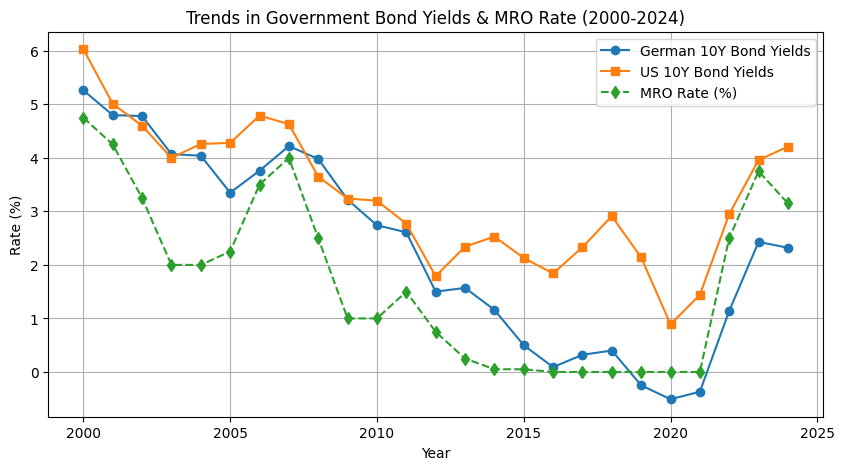

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(df["Date"], df["German 10-Year Government Bond Yields (%)"], marker='o', label="German 10Y Bond Yields")
plt.plot(df["Date"], df["US 10-Year Government Benchmark Bond Yield (%)"], marker='s', label="US 10Y Bond Yields")
plt.plot(df["Date"], df["MRO Rate (%)"], marker='d', label="MRO Rate (%)", linestyle="dashed")
plt.xlabel("Year")
plt.ylabel("Rate (%)")
plt.title("Trends in Government Bond Yields & MRO Rate (2000-2024)")
plt.legend()
plt.grid()